<h2>Let's Start<h2>

Lets first discuss what we are given and what we have to predict.
About our dataset :

We have in our training data :- 
1. date - every date of items sold
2. date_block_num - this number given to every month
3. shop_id - unique number of every shop
4. item_id - unique number of every item
5. item_price - price of every item
6. item_cnt_day - number of items sold on a particular day 

We have in our testing data :- 
1. ID - unique for every (shop_id,item_id) pair.
2. shop_id - unique number of every shop
3. item_id - unique number of every item

Now what we have to predict ?
we have to predict how many items of a type from each shop  will be sold in a whole month.
Our submission should have ID and item_cnt_month columns.

What is our approach?
our approach will be simple.
Our features will be number of items sold in month from a shop excluding last month data because that will our labels, that we help our model learn to predict next sequence. And for testing will use number of items sold in month from a shop excluding first month like this dimension of our data remains same. Our model will predict the next sequence and that we will be our results. This is pretty simple approach but its good for start. Please try some different approaches also. 
And please let me know if I did something wrong. If you like it please vote it up.


<h3>I would appreciate if you could upvote this kernel.<h3>

First of all as we know import required libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# importing libraries required for our model
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [11]:
#loading data 
# os.listdir('data')
# sales_data = pd.read_csv('/sales_train.csv')
# item_cat = pd.read_csv('../content/item_categories.csv')
# items = pd.read_csv('../content/items.csv')
# shops = pd.read_csv('../content/shops.csv')
# sample_submission = pd.read_csv('../content/sample_submission.csv')
# test_data = pd.read_csv('../content/test.csv')

items = pd.read_csv('input/items.csv')
shops = pd.read_csv('input/shops.csv')
item_cat = pd.read_csv('input/item_categories.csv')
sales_data = pd.read_csv('input/sales_train.csv')
sample_submission = pd.read_csv('input/sample_submission.csv')
# set index to ID to avoid droping it later
test_data  = pd.read_csv('input/test.csv').set_index('ID')


In [12]:
sales_data.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [13]:
test_data.head(3)

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233


In [14]:
sample_submission.head(3)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


In [15]:
def basic_eda(df):
    print("----------TOP 5 RECORDS--------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("----------Columns--------------")
    print(df.columns)
    print("----------Data Types-----------")
    print(df.dtypes)
    print("-------Missing Values----------")
    print(df.isnull().sum())
    print("-------NULL values-------------")
    print(df.isna().sum())
    print("-----Shape Of Data-------------")
    print(df.shape)
    
    

In [16]:
#Litle bit of exploration of data

print("=============================Sales Data=============================")
basic_eda(sales_data)
print("=============================Test data=============================")
basic_eda(test_data)
print("=============================Item Categories=============================")
basic_eda(item_cat)
print("=============================Items=============================")
basic_eda(items)
print("=============================Shops=============================")
basic_eda(shops)
print("=============================Sample Submission=============================")
basic_eda(sample_submission)



=============================Sales Data=============================
----------TOP 5 RECORDS--------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
----------

In [17]:
#we can see that 'date' column in sales_data is an object but if we want to manipulate 
#it or want to work on it someway then we have convert it on datetime format
sales_data['date'] = pd.to_datetime(sales_data['date'],format = '%d.%m.%Y')

In [18]:
sales_data.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0
2,2013-01-05,0,25,2552,899.0,-1.0


In [19]:
#now we will create a pivot tabel by going so we get our data in desired form 
#we want get total count value of an item over the whole month for a shop 
# That why we made shop_id and item_id our indices and date_block_num our column 
# the value we want is item_cnt_day and used sum as aggregating function 
dataset = sales_data.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')

In [20]:
dataset.head(3)

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  

[3 rows x 34 columns]

In [21]:
# lets reset our indices, so that data should be in way we can easily manipulate
dataset.reset_index(inplace = True)

In [22]:
# lets check on our pivot table
dataset.head(3)

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  

[3 rows x 36 columns]

In [23]:
# Now we will merge our pivot table with the test_data because we want to keep the data of items we have
# predict
dataset = pd.merge(test_data,dataset,on = ['item_id','shop_id'],how = 'left')

c:\users\decrypt\appdata\local\programs\python\python37\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
c:\users\decrypt\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [24]:
dataset.head()

,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# lets fill all NaN values with 0
dataset.fillna(0,inplace = True)
# lets check our data now 
dataset.head()

,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# we will drop shop_id and item_id because we do not need them
# we are teaching our model how to generate the next sequence 
dataset.drop(['shop_id','item_id'],inplace = True, axis = 1)
dataset.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
# the last column is our label
y_train = dataset.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)


(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [28]:
# our defining our model 
model_lstm = Sequential()
model_lstm.add(LSTM(units = 64,input_shape = (X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(1))

model_lstm.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [29]:
history_lstm = model_lstm.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
53/53 [==============================] - 31s 583ms/step - loss: 30.5415 - mean_squared_error: 30.5415
Epoch 2/10
53/53 [==============================] - 32s 611ms/step - loss: 30.2047 - mean_squared_error: 30.2047
Epoch 3/10
53/53 [==============================] - 35s 659ms/step - loss: 30.0716 - mean_squared_error: 30.0716
Epoch 4/10
53/53 [==============================] - 32s 602ms/step - loss: 29.9709 - mean_squared_error: 29.9709
Epoch 5/10
53/53 [==============================] - 34s 635ms/step - loss: 29.7848 - mean_squared_error: 29.7848
Epoch 6/10
53/53 [==============================] - 32s 595ms/step - loss: 29.7475 - mean_squared_error: 29.7475
Epoch 7/10
53/53 [==============================] - 31s 580ms/step - loss: 29.7582 - mean_squared_error: 29.7582
Epoch 8/10
53/53 [==============================] - 30s 566ms/step - loss: 29.6186 - mean_squared_error: 29.6186
Epoch 9/10
53/53 [==============================] - 30s 560ms/step - loss: 29.5470 - mean_square

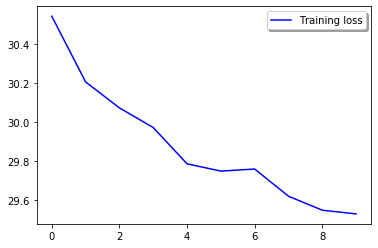

In [30]:
# Plot the loss curves for training
plt.plot(history_lstm.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

In [47]:
# # creating submission file 
# submission_pfs = model_lstm.predict(X_test)
# # we will keep every value between 0 and 20
# submission_pfs = submission_pfs.clip(0,20)


In [55]:
dataset.to_csv('input/feature.csv', index=False)


In [58]:
dataset2 = pd.read_csv('input/feature.csv')

In [60]:
dataset2.columns

Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33'],
      dtype='object')

In [62]:
X_train2 = dataset2[['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32']]
y_train2 = dataset2[['f_33']]

X_test2 = dataset2[['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33']]

In [67]:
X_train3 = X_train2.to_numpy()
y_train3 = y_train2.to_numpy()
X_test3 = X_test2.to_numpy()


print(X_train3.shape, y_train3.shape, X_test3.shape)

(214200, 33) (214200, 1) (214200, 33)


In [50]:
from xgboost import XGBRegressor

In [68]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train3, y_train3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
# make a one-step prediction
yhat = model.predict(X_test3)

In [72]:
yhat.shape

(214200,)

In [73]:
submission = pd.DataFrame(yhat, columns=['item_cnt_month'])

In [82]:
submission.reset_index(inplace=True)

In [85]:
submission2 = submission.rename(columns={"index": "ID"})

In [86]:
submission2.to_csv('input/submit5.csv', index=False)

In [91]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_train, yhat)